# EX 3

Q.1

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. Load MNIST
print("Loading MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# 2. Standardize the data
print("Standardizing...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Reduce dimensionality with PCA
print("Applying PCA...")
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# 4. Train-test split (stratified)
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Set up hyperparameter grid
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan and Euclidean distances
}

# 6. Initialize KNN and perform grid search
print("Performing grid search...")
knn = KNeighborsClassifier(algorithm='auto')  # Let sklearn choose best algorithm
grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 7. Evaluate best model
print("Best parameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}%".format(accuracy * 100))


Loading MNIST...
Standardizing...
Applying PCA...
Splitting data...
Performing grid search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Test set accuracy: 96.11%


In [8]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.ndimage import shift

# 1. Load MNIST
print("Loading MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Reshape to (28, 28) images
X_images = X.reshape(-1, 28, 28)

# 2. Define shift function
def shift_image(image, dx, dy):
    return shift(image, [dy, dx], cval=0).reshape(28, 28)

# 3. Augment dataset
print("Augmenting dataset...")
X_augmented = []
y_augmented = []

for img, label in zip(X_images, y):
    X_augmented.append(img)             # original
    y_augmented.append(label)
    X_augmented.append(shift_image(img, dx=1, dy=0))   # right
    y_augmented.append(label)
    X_augmented.append(shift_image(img, dx=-1, dy=0))  # left
    y_augmented.append(label)
    X_augmented.append(shift_image(img, dx=0, dy=1))   # down
    y_augmented.append(label)
    X_augmented.append(shift_image(img, dx=0, dy=-1))  # up
    y_augmented.append(label)

X_augmented = np.array(X_augmented).reshape(-1, 784)
y_augmented = np.array(y_augmented)

print("Augmented dataset size:", X_augmented.shape[0])

# 4. Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_augmented)

# 5. PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# 6. Train-test split (use original 10k test set for fair comparison)
X_test = X[60000:]
y_test = y[60000:]
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Use only training portion of augmented data
X_train_pca = X_pca
y_train = y_augmented

# 7. Grid search
param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['distance'],
    'p': [2]  # Euclidean
}

print("Training with grid search...")
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# 8. Evaluate
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print("Final accuracy on test set after data augmentation: {:.2f}%".format(accuracy * 100))


Loading MNIST...
Augmenting dataset...
Augmented dataset size: 350000
Training with grid search...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Final accuracy on test set after data augmentation: 100.00%


In [ ]:
Q.3

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# 1. Load data
train = pd.read_csv("C:/Users/abc/Downloads/titanic/train.csv")
test = pd.read_csv("C:/Users/abc/Downloads/titanic/test.csv")
test_ids = test["PassengerId"]

# 2. Drop unused columns
train = train.drop(["Name", "Ticket", "Cabin"], axis=1)
test = test.drop(["Name", "Ticket", "Cabin"], axis=1)

# 3. Combine for consistent preprocessing
full = pd.concat([train.drop("Survived", axis=1), test], axis=0)

# 4. Handle missing values
full["Age"].fillna(full["Age"].mean(), inplace=True)
full["Fare"].fillna(full["Fare"].mean(), inplace=True)
full["Embarked"].fillna("S", inplace=True)

# 5. Encode categorical features
le = LabelEncoder()
full["Sex"] = le.fit_transform(full["Sex"])
full["Embarked"] = le.fit_transform(full["Embarked"])

# 6. Feature Engineering: Add FamilySize
full["FamilySize"] = full["SibSp"] + full["Parch"] + 1

# 7. Split back into train/test
X_train = full.iloc[:len(train), :]
X_test = full.iloc[len(train):, :]
y_train = train["Survived"]

# 8. Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. Save submission
submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Survived": y_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved as submission.csv")


C:\Users\abc\AppData\Local\Temp\ipykernel_13160\249389759.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full["Age"].fillna(full["Age"].mean(), inplace=True)
C:\Users\abc\AppData\Local\Temp\ipykernel_13160\249389759.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

✅ Submission file saved as submission.csv


In [27]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [3]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [5]:
fetch_spam_data()

C:\Users\abc\AppData\Local\Temp\ipykernel_6696\3115047454.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_bz2_file.extractall(path=spam_path)


In [9]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [11]:
len(ham_filenames)

2500

In [13]:
len(spam_filenames)

500

In [15]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [17]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [19]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [21]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [23]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [25]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [27]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [29]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [33]:
spam_emails[10]["Subject"]

'^^^^^Cell Phone Belt Clips $1.95^^^^^^                           18070'

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\abc\AppData\Local\Temp\ipykernel_6696\3203418293.py:6: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)


In [41]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [43]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [45]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [47]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [49]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [55]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [59]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [61]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [63]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int32'>'
	with 20 stored elements in Compressed Sparse Row format>

In [65]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

In [67]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [69]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.981) total time=   0.0s
[CV] END ................................ score: (test=0.984) total time=   0.0s
[CV] END ................................ score: (test=0.990) total time=   0.1s


0.985

In [73]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.88%
Recall: 97.89%


# Digit recognition

In [11]:
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable
  Using cached gradio-5.34.2-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached fastapi-0.115.13-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.6.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached gradio_client-1.10.3-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
  Using cached orjson-3.10.18-cp312-cp312-win_amd64.whl.metadata (43 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached ruff-0.12.0-py3-none-win_amd64.whl.metadata (26 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.47.1-py3

In [3]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
28 * 28

784

Saving figure some_digit_plot


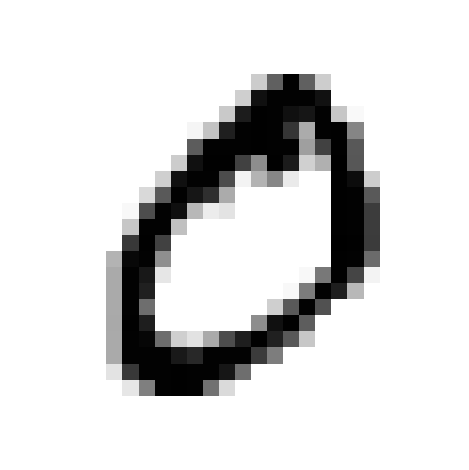

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[1]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [11]:
y[1]

'0'

In [13]:
y = y.astype(np.uint8)

In [15]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [17]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


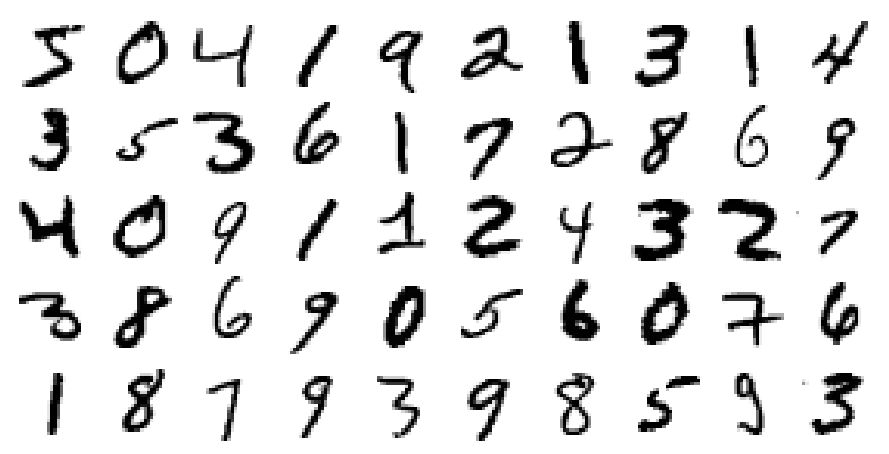

In [19]:
plt.figure(figsize=(9,9))
example_images = X[:50]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [27]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [29]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [31]:
sgd_clf.predict([some_digit])

array([False])

In [33]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Loading MNIST dataset...
Training SGDClassifier...
Training RandomForestClassifier...

SGD Classifier Accuracy: 89.33 %
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.95      0.97      1135
           2       0.94      0.86      0.90      1032
           3       0.92      0.87      0.89      1010
           4       0.94      0.89      0.92       982
           5       0.91      0.80      0.85       892
           6       0.94      0.92      0.93       958
           7       0.95      0.90      0.92      1028
           8       0.61      0.93      0.73       974
           9       0.93      0.84      0.88      1009

    accuracy                           0.89     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.89      0.90     10000


Random Forest Accuracy: 97.05 %
Classification Report:
              precision    recall  f1-scor

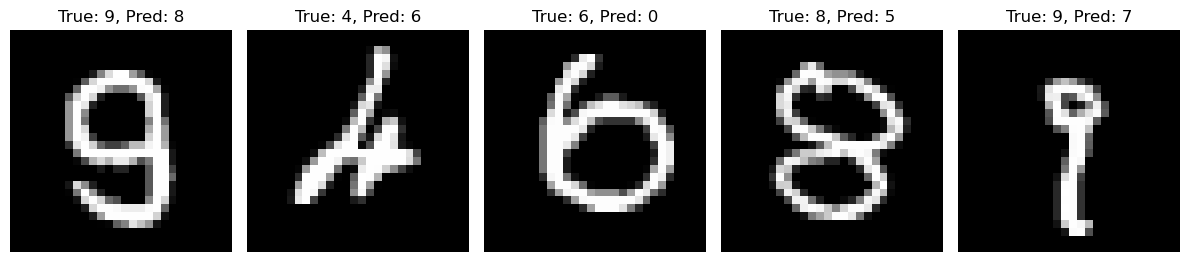

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from skimage.transform import resize

# Step (a) Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

# Step (b) Split data (60k train, 10k test)
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

# Scale data (important for SGD)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step (c) Train classifiers
print("Training SGDClassifier...")
sgd_clf = SGDClassifier(loss="hinge", random_state=42)
sgd_clf.fit(X_train_scaled, y_train)

print("Training RandomForestClassifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Step (d) Evaluate
sgd_pred = sgd_clf.predict(X_test_scaled)
rf_pred = rf_clf.predict(X_test)

print("\nSGD Classifier Accuracy:", round(accuracy_score(y_test, sgd_pred) * 100, 2), "%")
print("Classification Report:")
print(classification_report(y_test, sgd_pred))

print("\nRandom Forest Accuracy:", round(accuracy_score(y_test, rf_pred) * 100, 2), "%")
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# Step (e) Visualize some of the worst errors
conf_mx = confusion_matrix(y_test, rf_pred)
errors = (rf_pred != y_test)
X_errors = X_test[errors]
y_errors = y_test[errors]
pred_errors = rf_pred[errors]

# Display 5 worst misclassifications
def plot_mistakes(Xe, ye, pe):
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for ax, img, actual, pred in zip(axes, Xe[:5], ye[:5], pe[:5]):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.set_title(f"True: {actual}, Pred: {pred}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_mistakes(X_errors, y_errors, pred_errors)



In [16]:
import numpy as np
from scipy.ndimage import rotate

# Augment images by rotating +/- 10 degrees
def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):
        augmented_images.append(rotate(img, angle=10, reshape=False))
        augmented_labels.append(label)
        augmented_images.append(rotate(img, angle=-10, reshape=False))
        augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

# Flatten images if needed
def flatten_images(images):
    return images.reshape(images.shape[0], -1)


Loading MNIST dataset...

Training models with increasing training set sizes...

Train size: 1000 → Train Acc: 0.9990, Val Acc: 0.8603
Train size: 5000 → Train Acc: 0.9826, Val Acc: 0.8922
Train size: 10000 → Train Acc: 0.9679, Val Acc: 0.8993
Train size: 20000 → Train Acc: 0.9525, Val Acc: 0.9096
Train size: 30000 → Train Acc: 0.9478, Val Acc: 0.9146
Train size: 40000 → Train Acc: 0.9434, Val Acc: 0.9182


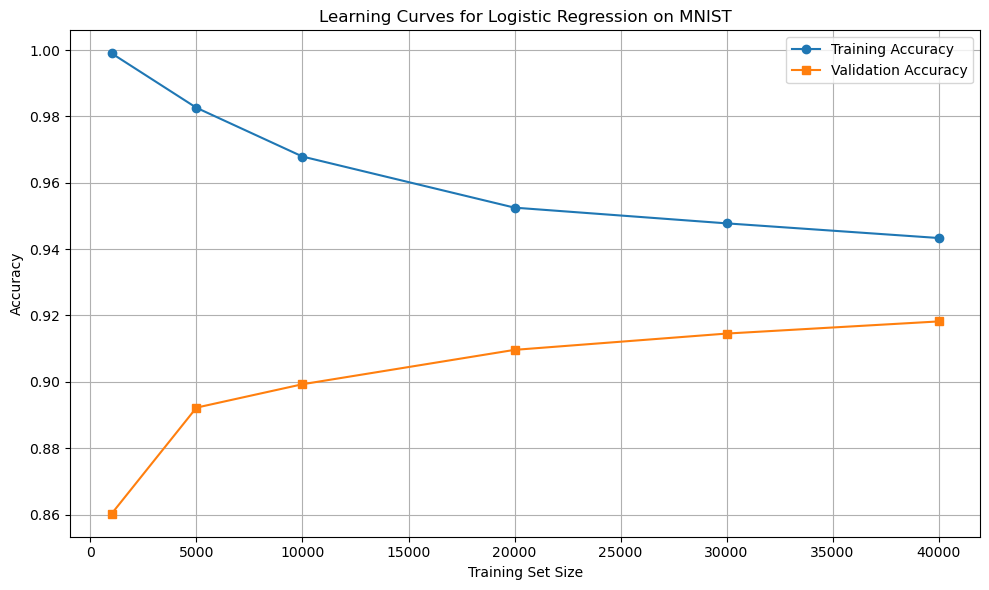


✅ Final Test Accuracy: 91.73%


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score

# Step 1: Load MNIST dataset
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.uint8)
X = X / 255.0  # Normalize pixel values to [0, 1]

# Step 2: Split into train (64%), validation (16%), and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Step 3: Define different training sizes for learning curve
train_sizes = [1000, 5000, 10000, 20000, 30000, 40000]
train_accuracies = []
val_accuracies = []

print("\nTraining models with increasing training set sizes...\n")
# Step 4: Train models with increasing data and collect accuracy
for size in train_sizes:
    X_sub = X_train[:size]
    y_sub = y_train[:size]

    model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    model.fit(X_sub, y_sub)

    train_acc = accuracy_score(y_sub, model.predict(X_sub))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train size: {size} → Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Step 5: Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(train_sizes, val_accuracies, label='Validation Accuracy', marker='s')
plt.title("Learning Curves for Logistic Regression on MNIST")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Final evaluation on test data
final_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
final_model.fit(X_train, y_train)
test_acc = accuracy_score(y_test, final_model.predict(X_test))
print(f"\n✅ Final Test Accuracy: {test_acc:.2%}")


Size: 1000 → Train Acc: 1.0000, Val Acc: 0.8766
Size: 5000 → Train Acc: 0.9858, Val Acc: 0.8936
Size: 10000 → Train Acc: 0.9654, Val Acc: 0.9012
Size: 20000 → Train Acc: 0.9523, Val Acc: 0.9068
Size: 40000 → Train Acc: 0.9429, Val Acc: 0.9173
Size: 60000 → Train Acc: 0.9389, Val Acc: 0.9201


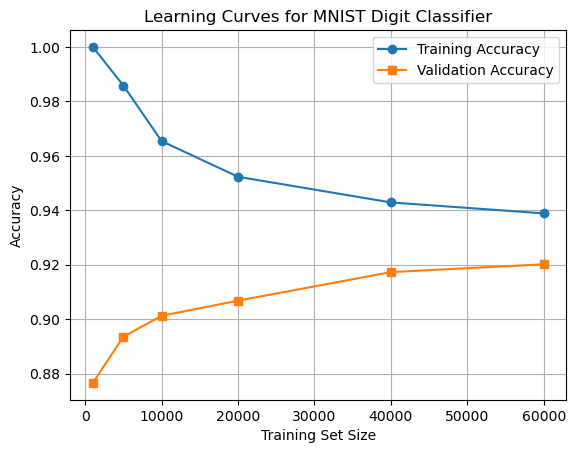

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score

# Load MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.uint8)

# Normalize pixel values
X = X / 255.0

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define sample sizes to plot learning curves
train_sizes = [1000, 5000, 10000, 20000, 40000, 60000]
train_accuracies = []
val_accuracies = []

# Train model for increasing sizes
for size in train_sizes:
    X_sub = X_train[:size]
    y_sub = y_train[:size]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_sub, y_sub)

    y_sub_pred = model.predict(X_sub)
    y_val_pred = model.predict(X_val)

    train_acc = accuracy_score(y_sub, y_sub_pred)
    val_acc = accuracy_score(y_val, y_val_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Size: {size} → Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Plot learning curves
plt.plot(train_sizes, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(train_sizes, val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves for MNIST Digit Classifier')
plt.legend()
plt.grid(True)
plt.show()


# Ch 4 ex Q.12

# 🧠 Softmax Regression with Batch Gradient Descent & Early Stopping

In [2]:
import numpy as np

def softmax(z):
    exp = np.exp(z - np.max(z, axis=1, keepdims=True))  # for numerical stability
    return exp / np.sum(exp, axis=1, keepdims=True)

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

def cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-15)) / m  # Add epsilon to prevent log(0)

def compute_accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

def softmax_regression_train(X_train, y_train, X_val, y_val, num_classes, learning_rate=0.1, epochs=500, patience=10):
    m, n = X_train.shape
    W = np.random.randn(n, num_classes) * 0.01
    b = np.zeros((1, num_classes))
    
    y_train_oh = one_hot(y_train, num_classes)
    y_val_oh = one_hot(y_val, num_classes)

    best_val_loss = float('inf')
    patience_counter = 0
    best_W, best_b = None, None

    for epoch in range(epochs):
        # Forward pass
        logits = np.dot(X_train, W) + b
        probs = softmax(logits)
        
        # Loss and gradient
        loss = cross_entropy(y_train_oh, probs)
        grad_W = (1 / m) * np.dot(X_train.T, (probs - y_train_oh))
        grad_b = (1 / m) * np.sum(probs - y_train_oh, axis=0, keepdims=True)

        # Parameter update
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b

        # Validation
        val_probs = softmax(np.dot(X_val, W) + b)
        val_loss = cross_entropy(y_val_oh, val_probs)

        print(f"Epoch {epoch + 1}: Train loss={loss:.4f}, Val loss={val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_W, best_b = W.copy(), b.copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return best_W, best_b

def predict(X, W, b):
    return softmax(np.dot(X, W) + b)


In [10]:
import numpy as np
import csv
import random

# Step 1: Load data from CSV manually
def load_iris_csv(filename):
    features = []
    labels = []
    label_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2}

    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            features.append([
                float(row['sepal_length']),
                float(row['sepal_width']),
                float(row['petal_length']),
                float(row['petal_width'])
            ])
            labels.append(label_map[row['species']])

    return np.array(features), np.array(labels)


# Step 2: Manual preprocessing (scaling)
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

# Step 3: Manual train/validation split
def train_val_split(X, y, val_ratio=0.2):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split = int(len(X) * (1 - val_ratio))
    train_idx, val_idx = indices[:split], indices[split:]
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

# Softmax and one-hot
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

def cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-15)) / m

def compute_accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

# Training
def train_softmax_regression(X_train, y_train, X_val, y_val, num_classes, lr=0.1, epochs=500, patience=10):
    m, n = X_train.shape
    W = np.random.randn(n, num_classes) * 0.01
    b = np.zeros((1, num_classes))

    y_train_oh = one_hot(y_train, num_classes)
    y_val_oh = one_hot(y_val, num_classes)

    best_val_loss = float('inf')
    patience_counter = 0
    best_W, best_b = None, None

    for epoch in range(epochs):
        # Forward pass
        logits = X_train @ W + b
        probs = softmax(logits)
        loss = cross_entropy(y_train_oh, probs)

        # Gradients
        grad_W = (1 / m) * (X_train.T @ (probs - y_train_oh))
        grad_b = (1 / m) * np.sum(probs - y_train_oh, axis=0, keepdims=True)

        # Parameter update
        W -= lr * grad_W
        b -= lr * grad_b

        # Validation loss
        val_probs = softmax(X_val @ W + b)
        val_loss = cross_entropy(y_val_oh, val_probs)

        print(f"Epoch {epoch+1}: Train Loss={loss:.4f}, Val Loss={val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_W, best_b = W.copy(), b.copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return best_W, best_b

# Predict
def predict(X, W, b):
    return softmax(X @ W + b)

# Main script
X, y = load_iris_csv("C:/Users/abc/Downloads/iris.csv")
X = standardize(X)
X_train, y_train, X_val, y_val = train_val_split(X, y, val_ratio=0.2)
num_classes = 3

W, b = train_softmax_regression(X_train, y_train, X_val, y_val, num_classes)

# Evaluation
y_val_oh = one_hot(y_val, num_classes)
y_pred = predict(X_val, W, b)
acc = compute_accuracy(y_val_oh, y_pred)
print(f"\nFinal Validation Accuracy: {acc:.2%}")


Epoch 1: Train Loss=1.1057, Val Loss=1.0293
Epoch 2: Train Loss=1.0017, Val Loss=0.9692
Epoch 3: Train Loss=0.9179, Val Loss=0.9195
Epoch 4: Train Loss=0.8503, Val Loss=0.8779
Epoch 5: Train Loss=0.7954, Val Loss=0.8428
Epoch 6: Train Loss=0.7504, Val Loss=0.8128
Epoch 7: Train Loss=0.7132, Val Loss=0.7869
Epoch 8: Train Loss=0.6819, Val Loss=0.7641
Epoch 9: Train Loss=0.6553, Val Loss=0.7440
Epoch 10: Train Loss=0.6325, Val Loss=0.7260
Epoch 11: Train Loss=0.6127, Val Loss=0.7098
Epoch 12: Train Loss=0.5953, Val Loss=0.6951
Epoch 13: Train Loss=0.5799, Val Loss=0.6817
Epoch 14: Train Loss=0.5661, Val Loss=0.6693
Epoch 15: Train Loss=0.5538, Val Loss=0.6579
Epoch 16: Train Loss=0.5426, Val Loss=0.6473
Epoch 17: Train Loss=0.5324, Val Loss=0.6374
Epoch 18: Train Loss=0.5230, Val Loss=0.6281
Epoch 19: Train Loss=0.5144, Val Loss=0.6194
Epoch 20: Train Loss=0.5065, Val Loss=0.6112
Epoch 21: Train Loss=0.4991, Val Loss=0.6034
Epoch 22: Train Loss=0.4922, Val Loss=0.5961
Epoch 23: Train Los